# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters

In [2]:
# Example usage:
n, m, p, q, T, sigma = 15, 13, 14, 12, 1000, 1
k, l, i, j = np.random.randint(0, m), np.random.randint(0, q), np.random.randint(0, n), np.random.randint(0, p)

In [3]:
def generate_matrices(n, m, p, q, T, sigma):
    """
    Generate matrices A, B, X_t, and Y_t as per the problem statement.

    Parameters:
    n (int): Number of rows in matrix A
    m (int): Number of columns in matrix A
    p (int): Number of columns in matrix B
    q (int): Number of rows in matrix B
    T (int): Number of matrices X_t and Y_t

    Returns:
    A (numpy array): Matrix A of size n x m with L1 normalized rows
    B (numpy array): Matrix B of size q x p with random entries
    E_t (list of numpy arrays): List of T matrices E_t of size n x p with random gaussian entries
    X_t (list of numpy arrays): List of T matrices X_t of size m x q with random entries
    M_t (list of numpy arrays): List of T matrices M_t resulting from A X_t B
    Y_t (list of numpy arrays): List of T matrices Y_t resulting from A X_t B + E_t
    """
    # Generate matrix A with L1 normalized rows
    A = np.random.rand(n, m)
    A = A / A.sum(axis=1, keepdims=True)

    # Generate matrix B with random entries
    B = np.random.rand(q, p)

    # Generate T matrices X_t with random entries
    X = [np.random.rand(m, q) for _ in range(T)]

    # Generate the matrix XX 
    XX = np.array([X_t.flatten('F') for X_t in X])

    # Generate T matrices E_t with normal entries
    E = [np.random.normal(loc=0, scale=sigma, size=(n, p)) for _ in range(T)]

    # Generate corresponding M_t matrices, signal
    M = [np.dot(np.dot(A, Xt), B) for Xt in X]

    # Generate the matrix MM 
    MM = np.array([M_t.flatten('F') for M_t in M])

    # Generate corresponding Y_t matrices, observations
    Y = [M[t] + E[t] for t in range(T)]

    # Generate the matrix YY
    YY = np.array([Y_t.flatten('F') for Y_t in Y])

    XX_T_XX = np.dot(XX.T, XX)
    XX_T_XX_inv = np.linalg.inv(XX_T_XX)
    XX_T = XX.T
    
    CC = np.dot(np.dot(XX_T_XX_inv, XX_T), MM)
    hat_CC = np.dot(np.dot(XX_T_XX_inv, XX_T), YY)

    hat_A = np.empty((n, m))
    for i in range(1, n+1):
        for k in range(1, m+1):
            x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
            hat_A[i-1, k-1] = min(max(0, x), 1)
    
    hat_B = np.empty((q, p))
    for l in range(1, q+1):
        for j in range(1, p+1):
            hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n

    return A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B

In [4]:
A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B = generate_matrices(n, m, p, q, T, sigma)

/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n


# Verify that $\left[\mathbb{C}\right]_{(k, l),(i,j)} = [A^*]_{ik} [B^*]_{lj}$

In [5]:
for k in range(1, m+1):
    for l in range(1, q+1):
        for i in range(1, n+1):
            for j in range(1, p+1):
                if np.round(CC[k + (l-1)*m - 1, i + (j-1)*n - 1], 8) != np.round(A[i-1, k-1] * B[l-1, j-1], 8):
                    print('BREAK')

# Verify that $[B^*]_{lj} =  \sum \limits_{k=1}^m \left[\mathbb{C}\right]_{(k, l),(i,j)},$

In [6]:
for k in range(1, m+1):
    for l in range(1, q+1):
        for i in range(1, n+1):
            for j in range(1, p+1):
                if np.round(B[l-1, j-1], 8) != np.round(np.sum(CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n , 8):
                    print('BREAK')

/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/2885224857.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if np.round(B[l-1, j-1], 8) != np.round(np.sum(CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n , 8):


# Verify that $[A^*]_{ik} = \dfrac{ \left[\mathbb{C}\right]_{(k, l),(i,j)}}{[B^*]_{lj} } $

In [7]:
for k in range(1, m+1):
    for l in range(1, q+1):
        for i in range(1, n+1):
            for j in range(1, p+1):
                if np.round(A[i-1, k-1], 8) != np.round(np.sum(CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1)), 8):
                    print('BREAK')

/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/884340258.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if np.round(A[i-1, k-1], 8) != np.round(np.sum(CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1)), 8):


# Build estimators

In [8]:
max_norm_A_error_list = []
Frob_norm_A_error_list = []
op_norm_A_error_list = []
max_norm_B_error_list = []
Frob_norm_B_error_list = []
op_norm_B_error_list = []

max_norm_A_error_list_p = []
Frob_norm_A_error_list_p = []
op_norm_A_error_list_p = []
max_norm_B_error_list_p = []
Frob_norm_B_error_list_p = []
op_norm_B_error_list_p = []

max_norm_A_error_list_q = []
Frob_norm_A_error_list_q = []
op_norm_A_error_list_q = []
max_norm_B_error_list_q = []
Frob_norm_B_error_list_q = []
op_norm_B_error_list_q = []

max_norm_A_error_list_n = []
Frob_norm_A_error_list_n = []
op_norm_A_error_list_n = []
max_norm_B_error_list_n = []
Frob_norm_B_error_list_n = []
op_norm_B_error_list_n = []

max_norm_A_error_list_m = []
Frob_norm_A_error_list_m = []
op_norm_A_error_list_m = []
max_norm_B_error_list_m = []
Frob_norm_B_error_list_m = []
op_norm_B_error_list_m = []

T_coef_min = 10
T_coef_max = 1000

for TT in tqdm(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), desc="Augmenting the number of observations"):
    A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B = generate_matrices(n, m, p, q, TT, sigma)
    max_norm_A_error_list.append(np.max(np.abs(A - hat_A)))
    Frob_norm_A_error_list.append(np.linalg.norm(A - hat_A, ord='fro'))
    op_norm_A_error_list.append(np.linalg.norm(A - hat_A, ord=2))
    max_norm_B_error_list.append(np.max(np.abs(B - hat_B)))
    Frob_norm_B_error_list.append(np.linalg.norm(B - hat_B, ord='fro'))
    op_norm_B_error_list.append(np.linalg.norm(B - hat_B, ord=2))

Augmenting the number of observations:   0%|          | 0/1545 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n
Augmenting the number of obser

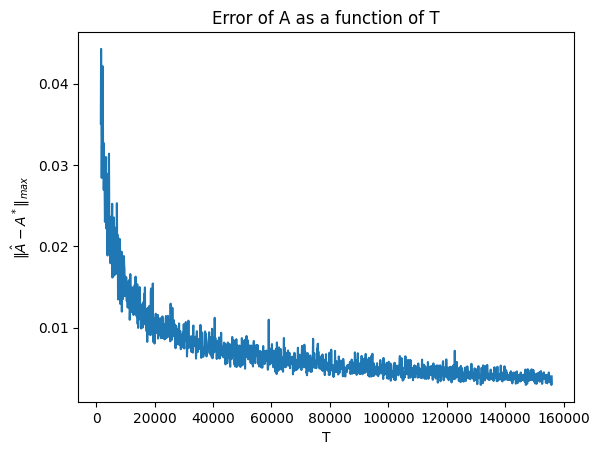

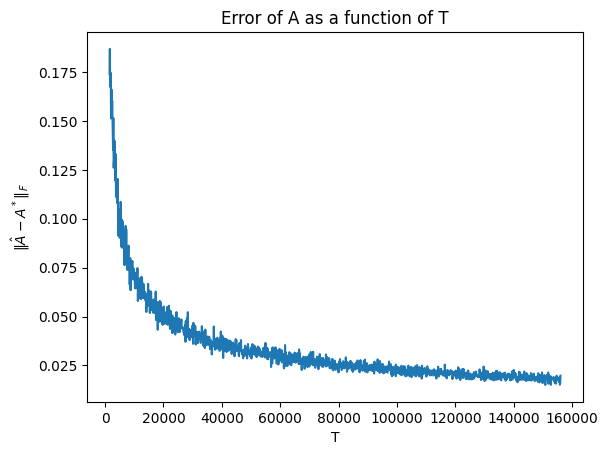

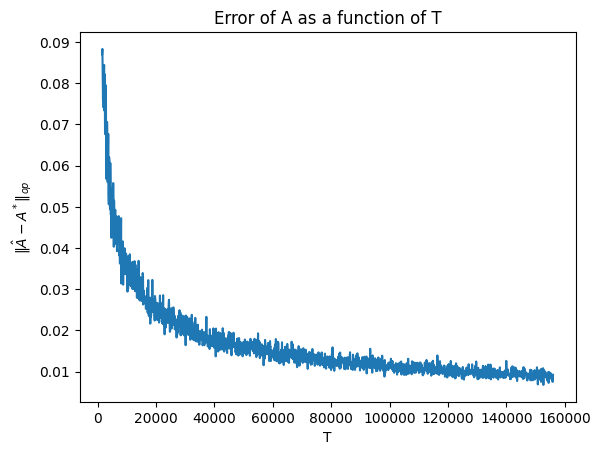

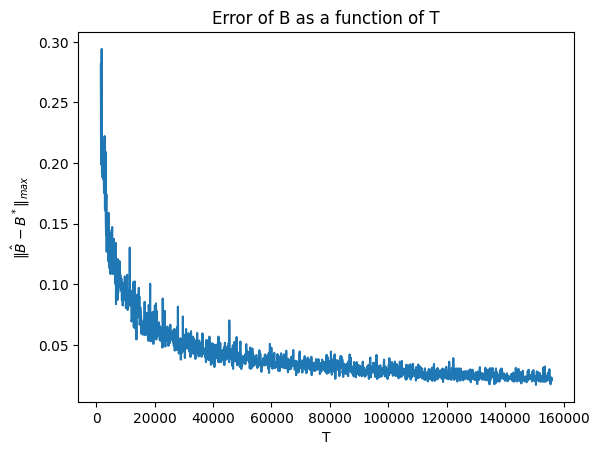

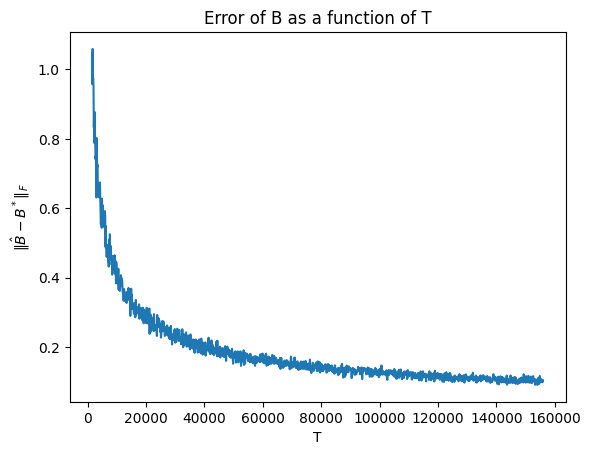

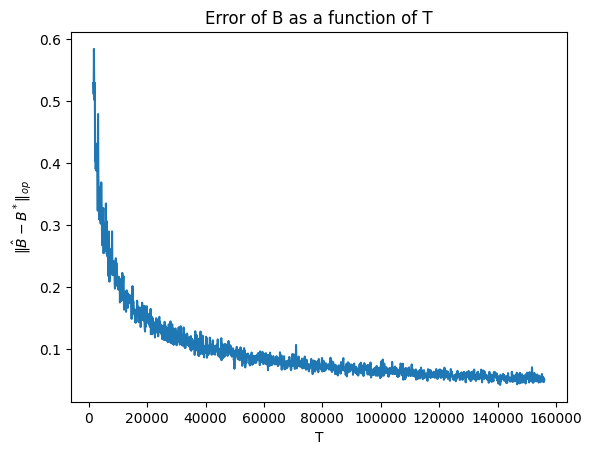

In [9]:
plt.plot(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), max_norm_A_error_list)
plt.xlabel('T')
plt.ylabel(r'$\| \hat{A} - A^*\|_{max}$')
plt.title('Error of A as a function of T')
plt.show()

plt.plot(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), Frob_norm_A_error_list)
plt.xlabel('T')
plt.ylabel(r'$\| \hat{A} - A^*\|_{F}$')
plt.title('Error of A as a function of T')
plt.show()

plt.plot(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), op_norm_A_error_list)
plt.xlabel('T')
plt.ylabel(r'$\| \hat{A} - A^*\|_{op}$')
plt.title('Error of A as a function of T')
plt.show()

plt.plot(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), max_norm_B_error_list)
plt.xlabel('T')
plt.ylabel(r'$\| \hat{B} - B^*\|_{max}$')
plt.title('Error of B as a function of T')
plt.show()

plt.plot(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), Frob_norm_B_error_list)
plt.xlabel('T')
plt.ylabel(r'$\| \hat{B} - B^*\|_{F}$')
plt.title('Error of B as a function of T')
plt.show()

plt.plot(range(T_coef_min*m*q+1, T_coef_max*m*q, 100), op_norm_B_error_list)
plt.xlabel('T')
plt.ylabel(r'$\| \hat{B} - B^*\|_{op}$')
plt.title('Error of B as a function of T')
plt.show()

In [10]:
p_min = 2
p_max = 100
for pp in tqdm(range(p_min, p_max), desc="Augmenting the number of observations"):
    A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B = generate_matrices(n, m, pp, q, T_coef_max*m*q, sigma)
    max_norm_A_error_list_p.append(np.max(np.abs(A - hat_A)))
    Frob_norm_A_error_list_p.append(np.linalg.norm(A - hat_A, ord='fro'))
    op_norm_A_error_list_p.append(np.linalg.norm(A - hat_A, ord=2))
    max_norm_B_error_list_p.append(np.max(np.abs(B - hat_B)))
    Frob_norm_B_error_list_p.append(np.linalg.norm(B - hat_B, ord='fro'))
    op_norm_B_error_list_p.append(np.linalg.norm(B - hat_B, ord=2))

Augmenting the number of observations:   0%|          | 0/98 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n
Augmenting the number of observa

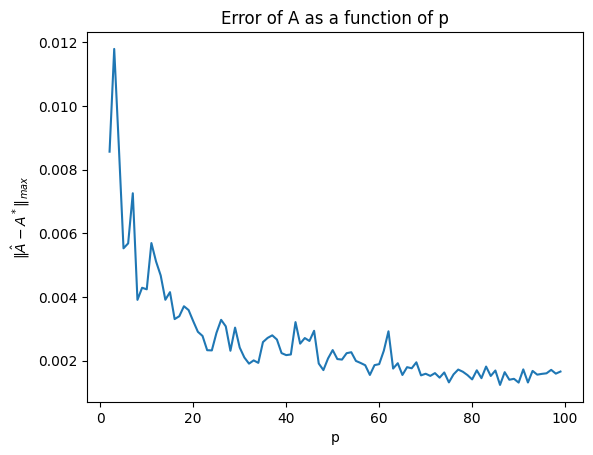

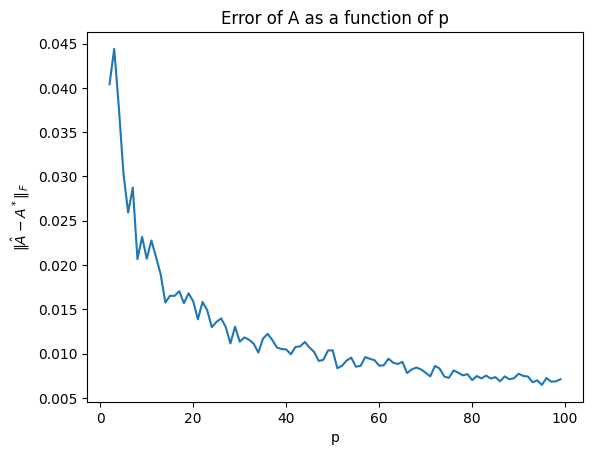

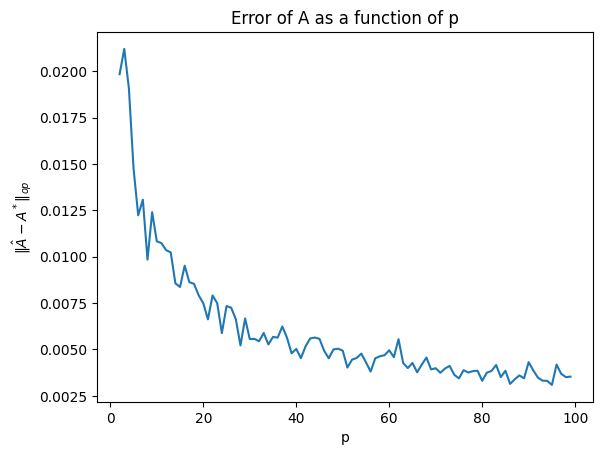

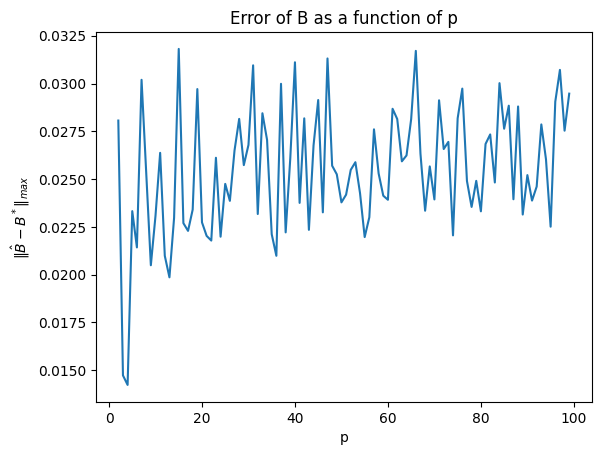

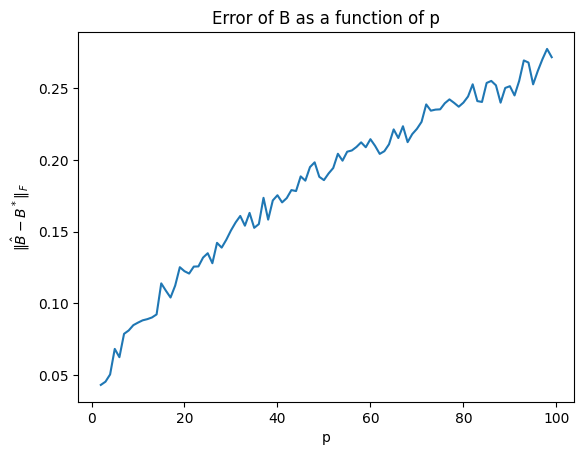

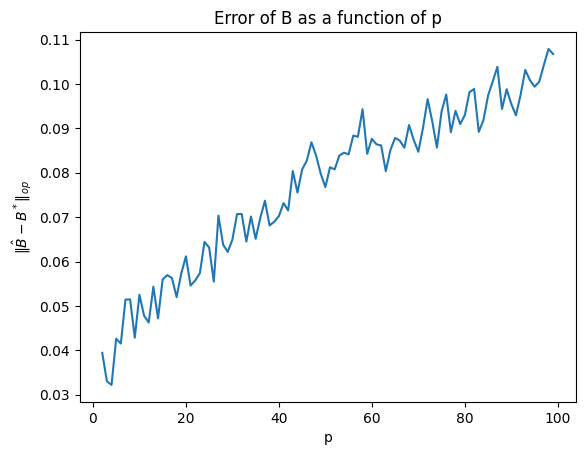

In [11]:
plt.plot(range(p_min, p_max), max_norm_A_error_list_p)
plt.xlabel('p')
plt.ylabel(r'$\| \hat{A} - A^*\|_{max}$')
plt.title('Error of A as a function of p')
plt.show()

plt.plot(range(p_min, p_max), Frob_norm_A_error_list_p)
plt.xlabel('p')
plt.ylabel(r'$\| \hat{A} - A^*\|_{F}$')
plt.title('Error of A as a function of p')
plt.show()

plt.plot(range(p_min, p_max), op_norm_A_error_list_p)
plt.xlabel('p')
plt.ylabel(r'$\| \hat{A} - A^*\|_{op}$')
plt.title('Error of A as a function of p')
plt.show()

plt.plot(range(p_min, p_max), max_norm_B_error_list_p)
plt.xlabel('p')
plt.ylabel(r'$\| \hat{B} - B^*\|_{max}$')
plt.title('Error of B as a function of p')
plt.show()

plt.plot(range(p_min, p_max), Frob_norm_B_error_list_p)
plt.xlabel('p')
plt.ylabel(r'$\| \hat{B} - B^*\|_{F}$')
plt.title('Error of B as a function of p')
plt.show()

plt.plot(range(p_min, p_max), op_norm_B_error_list_p)
plt.xlabel('p')
plt.ylabel(r'$\| \hat{B} - B^*\|_{op}$')
plt.title('Error of B as a function of p')
plt.show()

In [12]:
q_min = 2
q_max = 100
for qq in tqdm(range(q_min, q_max), desc="Augmenting the number of observations"):
    A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B = generate_matrices(n, m, p, qq, T_coef_max*m*q, sigma)
    max_norm_A_error_list_q.append(np.max(np.abs(A - hat_A)))
    Frob_norm_A_error_list_q.append(np.linalg.norm(A - hat_A, ord='fro'))
    op_norm_A_error_list_q.append(np.linalg.norm(A - hat_A, ord=2))
    max_norm_B_error_list_q.append(np.max(np.abs(B - hat_B)))
    Frob_norm_B_error_list_q.append(np.linalg.norm(B - hat_B, ord='fro'))
    op_norm_B_error_list_q.append(np.linalg.norm(B - hat_B, ord=2))

Augmenting the number of observations:   0%|          | 0/98 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n
Augmenting the number of observa

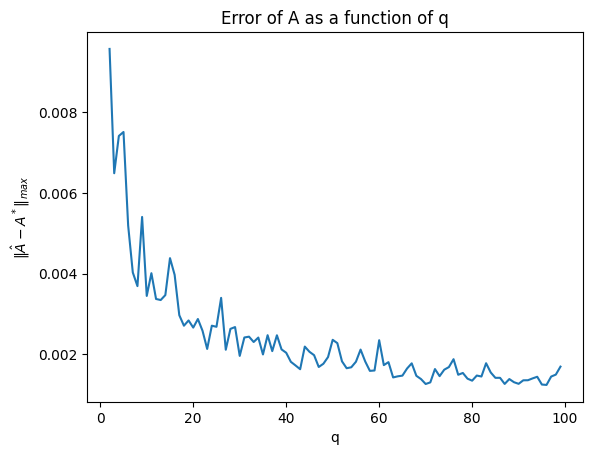

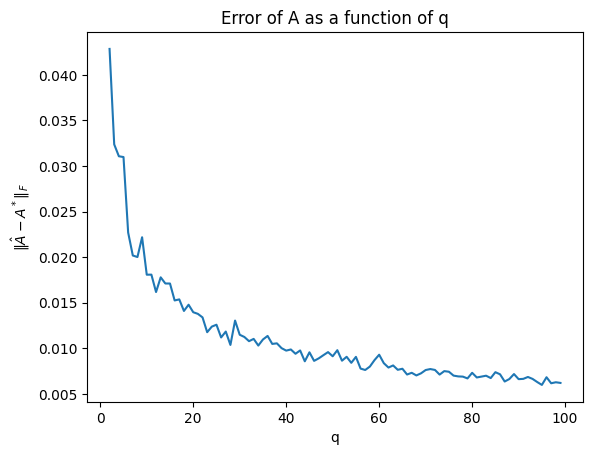

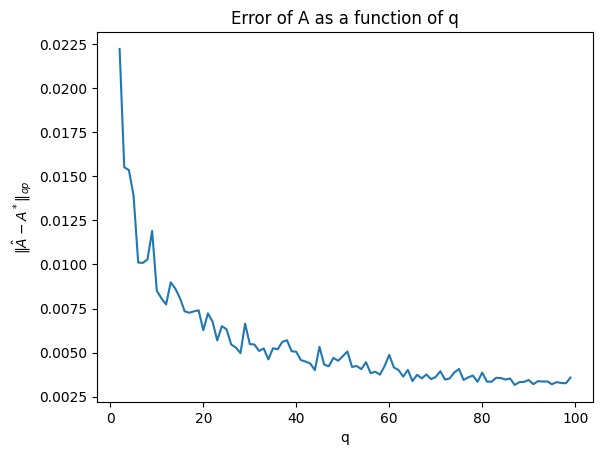

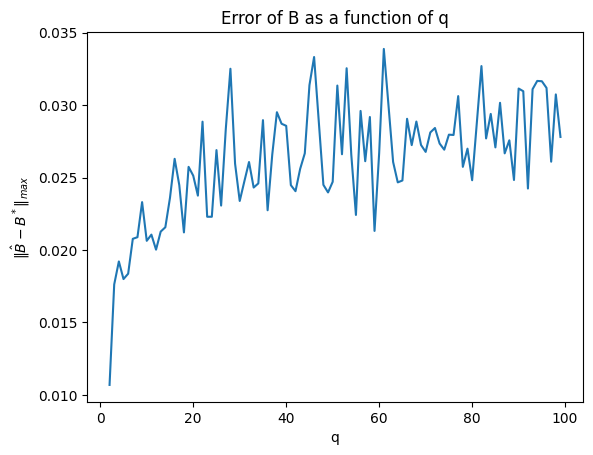

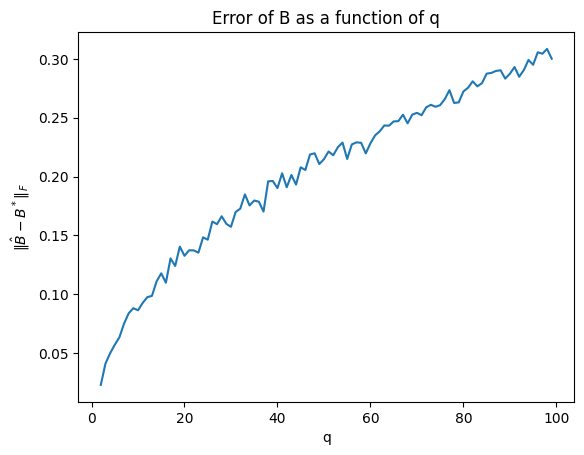

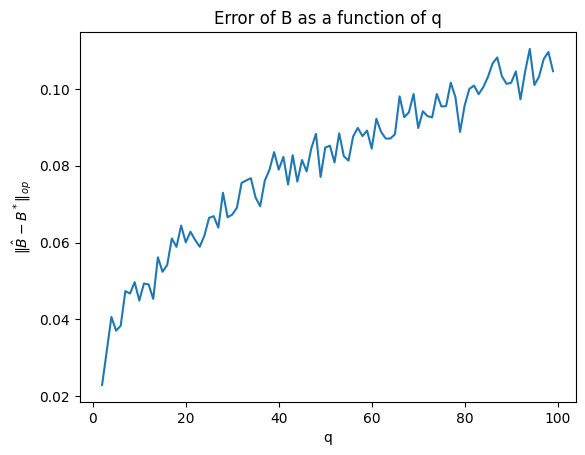

In [13]:
plt.plot(range(q_min, q_max), max_norm_A_error_list_q)
plt.xlabel('q')
plt.ylabel(r'$\| \hat{A} - A^*\|_{max}$')
plt.title('Error of A as a function of q')
plt.show()

plt.plot(range(q_min, q_max), Frob_norm_A_error_list_q)
plt.xlabel('q')
plt.ylabel(r'$\| \hat{A} - A^*\|_{F}$')
plt.title('Error of A as a function of q')
plt.show()

plt.plot(range(q_min, q_max), op_norm_A_error_list_q)
plt.xlabel('q')
plt.ylabel(r'$\| \hat{A} - A^*\|_{op}$')
plt.title('Error of A as a function of q')
plt.show()

plt.plot(range(q_min, q_max), max_norm_B_error_list_q)
plt.xlabel('q')
plt.ylabel(r'$\| \hat{B} - B^*\|_{max}$')
plt.title('Error of B as a function of q')
plt.show()

plt.plot(range(q_min, q_max), Frob_norm_B_error_list_q)
plt.xlabel('q')
plt.ylabel(r'$\| \hat{B} - B^*\|_{F}$')
plt.title('Error of B as a function of q')
plt.show()

plt.plot(range(q_min, q_max), op_norm_B_error_list_q)
plt.xlabel('q')
plt.ylabel(r'$\| \hat{B} - B^*\|_{op}$')
plt.title('Error of B as a function of q')
plt.show()

In [14]:
n_min = 2
n_max = 100
for nn in tqdm(range(n_min, n_max), desc="Augmenting the number of observations"):
    A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B = generate_matrices(nn, m, p, q, T_coef_max*m*q, sigma)
    max_norm_A_error_list_n.append(np.max(np.abs(A - hat_A)))
    Frob_norm_A_error_list_n.append(np.linalg.norm(A - hat_A, ord='fro'))
    op_norm_A_error_list_n.append(np.linalg.norm(A - hat_A, ord=2))
    max_norm_B_error_list_n.append(np.max(np.abs(B - hat_B)))
    Frob_norm_B_error_list_n.append(np.linalg.norm(B - hat_B, ord='fro'))
    op_norm_B_error_list_n.append(np.linalg.norm(B - hat_B, ord=2))

Augmenting the number of observations:   0%|          | 0/98 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n
Augmenting the number of observa

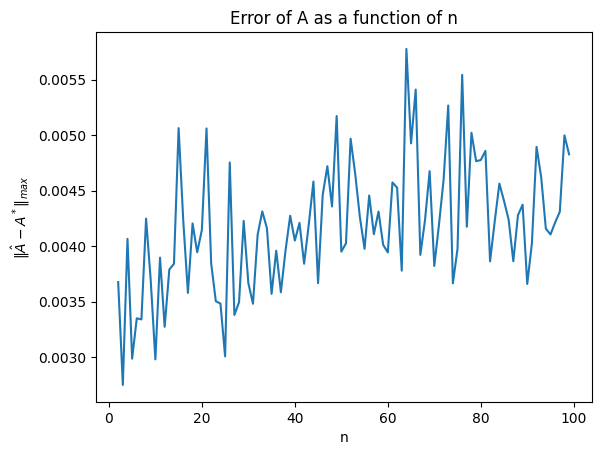

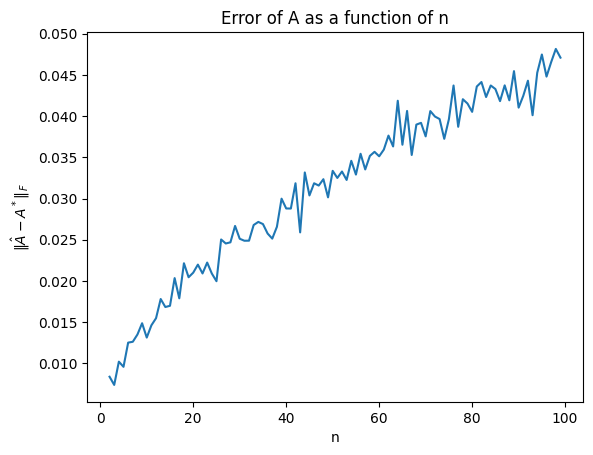

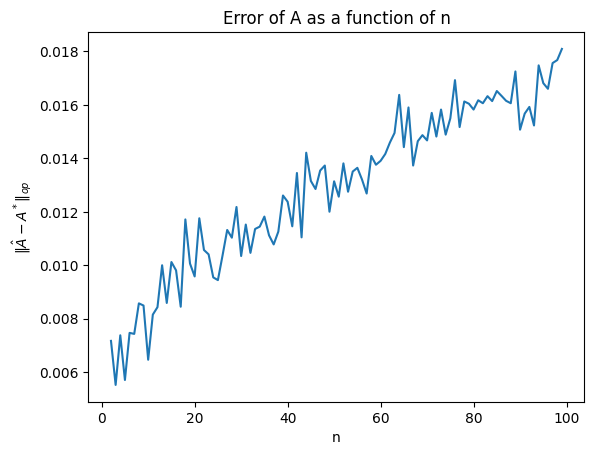

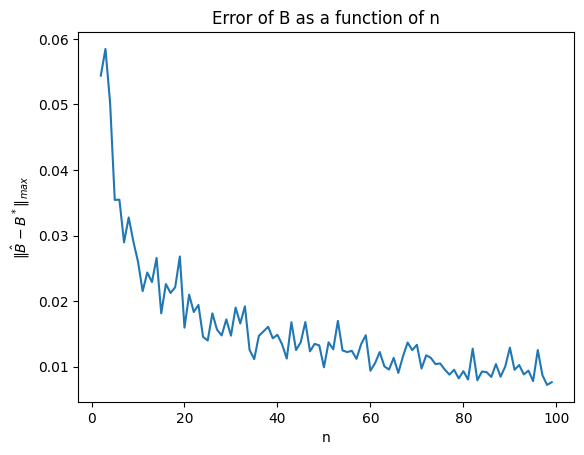

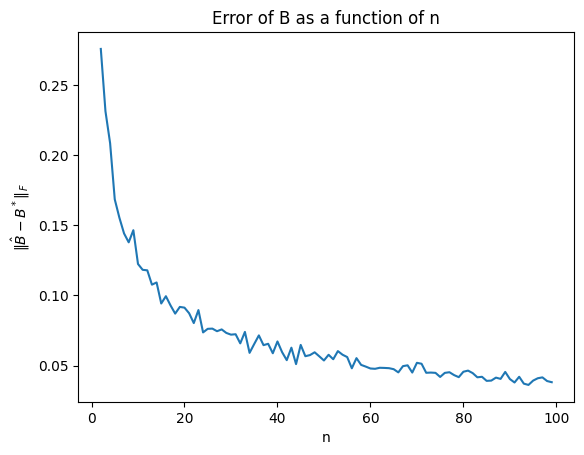

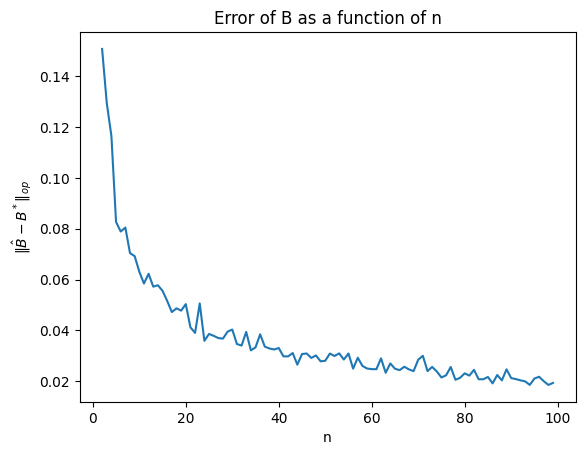

In [15]:
plt.plot(range(n_min, n_max), max_norm_A_error_list_n)
plt.xlabel('n')
plt.ylabel(r'$\| \hat{A} - A^*\|_{max}$')
plt.title('Error of A as a function of n')
plt.show()

plt.plot(range(n_min, n_max), Frob_norm_A_error_list_n)
plt.xlabel('n')
plt.ylabel(r'$\| \hat{A} - A^*\|_{F}$')
plt.title('Error of A as a function of n')
plt.show()

plt.plot(range(n_min, n_max), op_norm_A_error_list_n)
plt.xlabel('n')
plt.ylabel(r'$\| \hat{A} - A^*\|_{op}$')
plt.title('Error of A as a function of n')
plt.show()

plt.plot(range(n_min, n_max), max_norm_B_error_list_n)
plt.xlabel('n')
plt.ylabel(r'$\| \hat{B} - B^*\|_{max}$')
plt.title('Error of B as a function of n')
plt.show()

plt.plot(range(n_min, n_max), Frob_norm_B_error_list_n)
plt.xlabel('n')
plt.ylabel(r'$\| \hat{B} - B^*\|_{F}$')
plt.title('Error of B as a function of n')
plt.show()

plt.plot(range(n_min, n_max), op_norm_B_error_list_n)
plt.xlabel('n')
plt.ylabel(r'$\| \hat{B} - B^*\|_{op}$')
plt.title('Error of B as a function of n')
plt.show()

In [16]:
m_min = 2
m_max = 100
for mm in tqdm(range(n_min, n_max), desc="Augmenting the number of observations"):
    A, B, X, E, M, Y, XX, MM, CC, hat_CC, hat_A, hat_B = generate_matrices(n, mm, p, q, T_coef_max*m*q, sigma)
    max_norm_A_error_list_m.append(np.max(np.abs(A - hat_A)))
    Frob_norm_A_error_list_m.append(np.linalg.norm(A - hat_A, ord='fro'))
    op_norm_A_error_list_m.append(np.linalg.norm(A - hat_A, ord=2))
    max_norm_B_error_list_m.append(np.max(np.abs(B - hat_B)))
    Frob_norm_B_error_list_m.append(np.linalg.norm(B - hat_B, ord='fro'))
    op_norm_B_error_list_m.append(np.linalg.norm(B - hat_B, ord=2))

Augmenting the number of observations:   0%|          | 0/98 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1)) * n / np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for l in range(1, q+1) for j in range(1, p+1) for k in range(1, m+1) for i in range(1, n+1))
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/1273344498.py:64: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  hat_B[l-1, j-1] = np.sum(hat_CC[k + (l-1)*m - 1, i + (j-1)*n - 1] for k in range(1, m+1) for i in range(1, n+1)) / n
Augmenting the number of observa

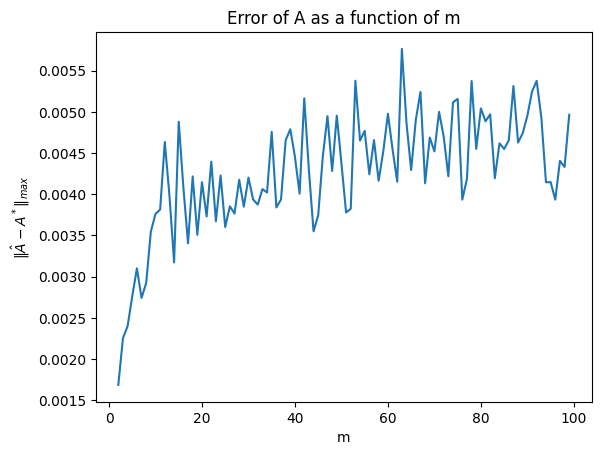

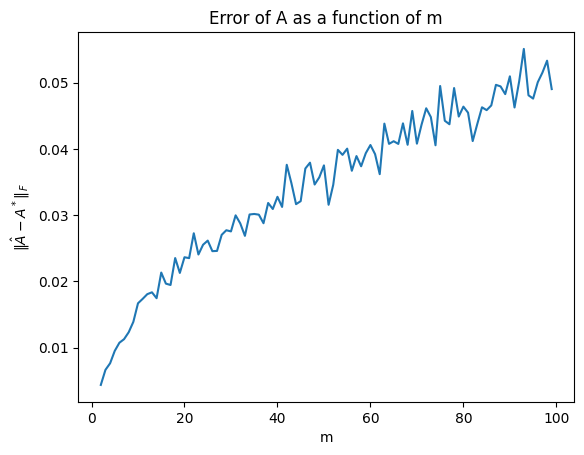

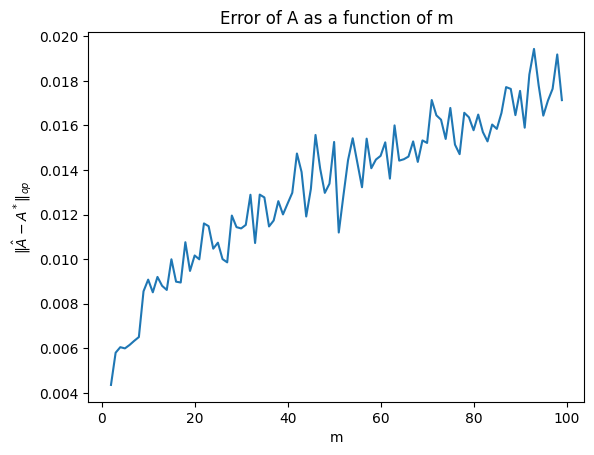

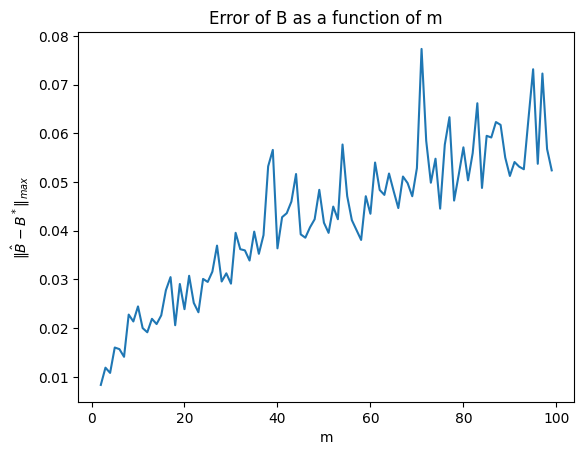

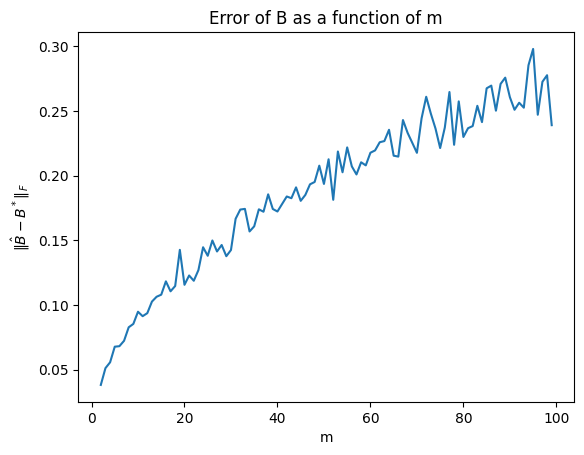

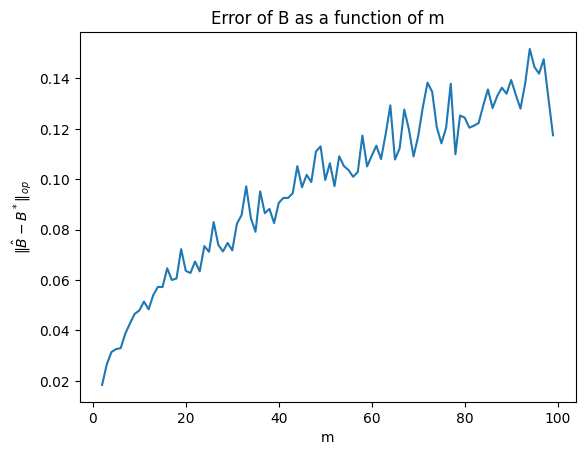

In [17]:
plt.plot(range(m_min, m_max), max_norm_A_error_list_m)
plt.xlabel('m')
plt.ylabel(r'$\| \hat{A} - A^*\|_{max}$')
plt.title('Error of A as a function of m')
plt.show()

plt.plot(range(m_min, m_max), Frob_norm_A_error_list_m)
plt.xlabel('m')
plt.ylabel(r'$\| \hat{A} - A^*\|_{F}$')
plt.title('Error of A as a function of m')
plt.show()

plt.plot(range(m_min, m_max), op_norm_A_error_list_m)
plt.xlabel('m')
plt.ylabel(r'$\| \hat{A} - A^*\|_{op}$')
plt.title('Error of A as a function of m')
plt.show()

plt.plot(range(m_min, m_max), max_norm_B_error_list_m)
plt.xlabel('m')
plt.ylabel(r'$\| \hat{B} - B^*\|_{max}$')
plt.title('Error of B as a function of m')
plt.show()

plt.plot(range(m_min, m_max), Frob_norm_B_error_list_m)
plt.xlabel('m')
plt.ylabel(r'$\| \hat{B} - B^*\|_{F}$')
plt.title('Error of B as a function of m')
plt.show()

plt.plot(range(m_min, m_max), op_norm_B_error_list_m)
plt.xlabel('m')
plt.ylabel(r'$\| \hat{B} - B^*\|_{op}$')
plt.title('Error of B as a function of m')
plt.show()

# CIFAR Dataset 

### Load data

In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Check dataset shapes
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


/Users/nbb45/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


### Plot an example

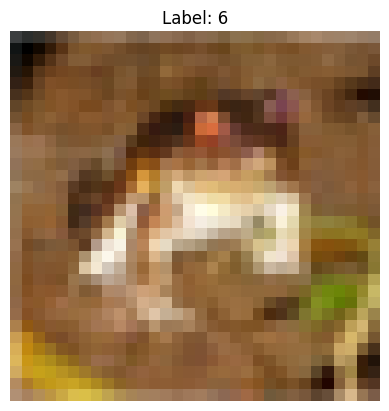

In [19]:
# Plot an example from the training set
index = 0  # Example index
plt.imshow(X_train[index])
plt.title(f"Label: {y_train[index][0]}")
plt.axis('off')
plt.show()

### Add noise

In [20]:
import numpy as np

np.random.seed(42)
# Define the noise level (adjust as needed)
noise_factor = 0.02

# Create noisy matrices for transformation
A_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
# Normalize each row to have unit L1 norm
A_noisy_L1 = A_noisy / np.abs(A_noisy).sum(axis=1, keepdims=True)
A_noisy_L1_inv = np.linalg.inv(A_noisy_L1)

B_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
B_noisy_inv = np.linalg.inv(B_noisy)

# Apply left and right multiplication to each image for all channels
def apply_noise_transform(image, A_noisy_L1, B_noisy):
    transformed_channels = [
        np.dot(np.dot(A_noisy_L1, channel), B_noisy) for channel in image.transpose(2, 0, 1)
    ]
    return np.stack(transformed_channels, axis=2)

# Apply the transformation to the training and test datasets
X_train_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_train])
X_test_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_test])

# Verify the shape of the modified datasets
print(f"Modified training data shape: {X_train_modified.shape}")
print(f"Modified test data shape: {X_test_modified.shape}")


Modified training data shape: (50000, 32, 32, 3)
Modified test data shape: (10000, 32, 32, 3)


### Plot noisy example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054265033..1.7501131].


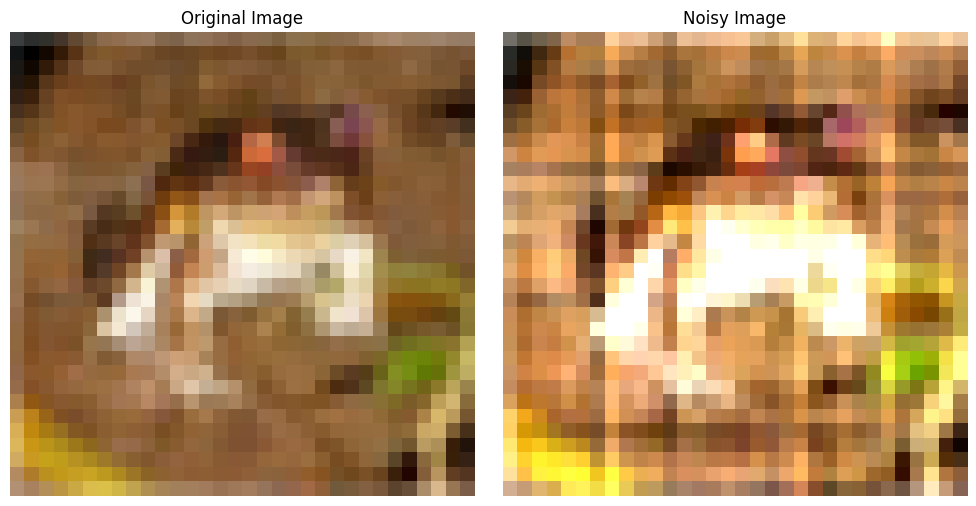

In [21]:
import matplotlib.pyplot as plt

index = 0  # Choose an image index
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(X_train[index])  # No 'cmap' needed for RGB images
plt.title("Original Image")
plt.axis('off')

# Modified image
plt.subplot(1, 2, 2)
plt.imshow(X_train_modified[index].astype('float32'))  # Ensure correct type for visualization
plt.title("Noisy Image")
plt.axis('off')

plt.tight_layout()
plt.show()


### Build estimators

In [22]:
# Reshape each channel of the CIFAR images into flattened rows
def reshape_by_channel(data):
    channels = []
    for c in range(data.shape[-1]):  # Loop through color channels (RGB)
        channel = data[..., c].reshape(data.shape[0], -1)  # Flatten each channel
        channels.append(channel)
    return channels

# Separate channels for original and modified datasets
X_train_channels = reshape_by_channel(X_train)
X_train_modified_channels = reshape_by_channel(X_train_modified)
X_test_channels = reshape_by_channel(X_test)
X_test_modified_channels = reshape_by_channel(X_test_modified)

# Initialize lists to store results for each channel
C_train_channels = []
C_test_channels = []

# Process each channel independently
for c in range(3):  # Loop through RGB channels
    # Original and modified channel matrices
    X_train_channel = X_train_channels[c]
    X_train_modified_channel = X_train_modified_channels[c]
    X_test_channel = X_test_channels[c]
    X_test_modified_channel = X_test_modified_channels[c]
    
    # Compute covariance matrices
    X_train_modified_T_X_train_modified = np.dot(X_train_modified_channel.T, X_train_modified_channel)
    X_test_modified_T_X_test_modified = np.dot(X_test_modified_channel.T, X_test_modified_channel)

    # Compute pseudo-inverse
    X_train_modified_inv = np.linalg.pinv(X_train_modified_T_X_train_modified)
    X_test_modified_inv = np.linalg.pinv(X_test_modified_T_X_test_modified)

    # Compute projection matrices
    C_train = np.dot(
        np.dot(X_train_modified_inv, X_train_modified_channel.T),
        X_train_channel
    )
    C_test = np.dot(
        np.dot(X_test_modified_inv, X_test_modified_channel.T),
        X_test_channel
    )

    # Append results for the channel
    C_train_channels.append(C_train)
    C_test_channels.append(C_test)

# Combine results for all channels if needed
C_X_train_modified_matrix_hat = np.stack(C_train_channels, axis=0)
C_X_test_modified_matrix_hat = np.stack(C_test_channels, axis=0)

# Output shapes for verification
print(f"Shape of projection matrix for training data (per channel): {C_train.shape}")
print(f"Shape of projection matrix for test data (per channel): {C_test.shape}")
print(f"Combined shape for training data: {C_X_train_modified_matrix_hat.shape}")
print(f"Combined shape for test data: {C_X_test_modified_matrix_hat.shape}")


Shape of projection matrix for training data (per channel): (1024, 1024)
Shape of projection matrix for test data (per channel): (1024, 1024)
Combined shape for training data: (3, 1024, 1024)
Combined shape for test data: (3, 1024, 1024)


In [23]:
def smallest_singular_value(matrix):
    """
    Compute the smallest singular value of a given matrix.
    """
    singular_values = np.linalg.svd(matrix, compute_uv=False)
    return np.min(singular_values)

# Compute the smallest singular value for each channel
smallest_singular_values_train = []
smallest_singular_values_test = []

for c in range(3):  # Loop through RGB channels
    # Compute for the training data
    s_train = smallest_singular_value(C_train_channels[c])
    smallest_singular_values_train.append(s_train)

    # Compute for the test data
    s_test = smallest_singular_value(C_test_channels[c])
    smallest_singular_values_test.append(s_test)

# Print the results for each channel
for c, (s_train, s_test) in enumerate(zip(smallest_singular_values_train, smallest_singular_values_test)):
    print(f"Channel {c} - Smallest Singular Value (Train): {s_train:.4e}")
    print(f"Channel {c} - Smallest Singular Value (Test): {s_test:.4e}")


Channel 0 - Smallest Singular Value (Train): 4.7939e-01
Channel 0 - Smallest Singular Value (Test): 4.7939e-01
Channel 1 - Smallest Singular Value (Train): 4.7939e-01
Channel 1 - Smallest Singular Value (Test): 4.7939e-01
Channel 2 - Smallest Singular Value (Train): 4.7939e-01
Channel 2 - Smallest Singular Value (Test): 4.7939e-01


In [24]:
from tqdm import tqdm
import numpy as np

# Initialize matrices to store results for each channel
hat_A_train_channels = []
hat_B_train_channels = []

for c in range(3):  # Loop through RGB channels
    # Extract dimensions for the current channel
    T, n, p, m, q = (X_train_modified_channels[c].shape[0],
                     32,
                     32,
                     32,
                     32)
    
    # Compute hat_A_train for the current channel
    hat_A_train = np.empty((n, m))
    for i in tqdm(range(1, n + 1), desc=f"Channel {c}: Computing hat_A_train"):
        for k in range(1, m + 1):
            numerator = np.sum(
                C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                for l in range(1, q + 1) for j in range(1, p + 1)
            )
            denominator = np.sum(
                C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                for l in range(1, q + 1) for j in range(1, p + 1)
                for k in range(1, m + 1) for i in range(1, n + 1)
            )
            tilde_A = numerator * n / denominator
            hat_A_train[i-1, k-1] = min(max(0, tilde_A), 1)
    
    hat_A_train_channels.append(hat_A_train)
    


Channel 0: Computing hat_A_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/4189155510.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/4189155510.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(
Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [03:22<00:00,  6.33s/it]


In [25]:
hat_B_train_channels = []  # Initialize list to store matrices for all channels

for c in range(3):  # Process all 3 channels (RGB)
    print(f"Processing channel {c} for hat_B_train")
    
    hat_B_train = np.empty((q, p))  # Initialize the matrix for the current channel
    
    for l in tqdm(range(1, q + 1), desc=f"Channel {c}: Computing hat_B_train"):
        for j in range(1, p + 1):
            numerator = np.sum(
                C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                for k in range(1, m + 1) for i in range(1, n + 1)
            )
            hat_B_train[l - 1, j - 1] = numerator / n
    
    hat_B_train_channels.append(hat_B_train)  # Add the matrix for the current channel

# Verify the size of hat_B_train_channels
print(f"Number of channels in hat_B_train_channels: {len(hat_B_train_channels)}")


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/472471318.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 159.20it/s]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 160.12it/s]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 159.09it/s]

Number of channels in hat_B_train_channels: 3


### Show results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0285932..1.4966482].


hat_A_train_channels[0].shape: (32, 32)
X_train_modified[index][..., 0].shape: (32, 32)
hat_B_train_channels[0].shape: (32, 32)
hat_A_train_channels[1].shape: (32, 32)
X_train_modified[index][..., 1].shape: (32, 32)
hat_B_train_channels[1].shape: (32, 32)
hat_A_train_channels[2].shape: (32, 32)
X_train_modified[index][..., 2].shape: (32, 32)
hat_B_train_channels[2].shape: (32, 32)


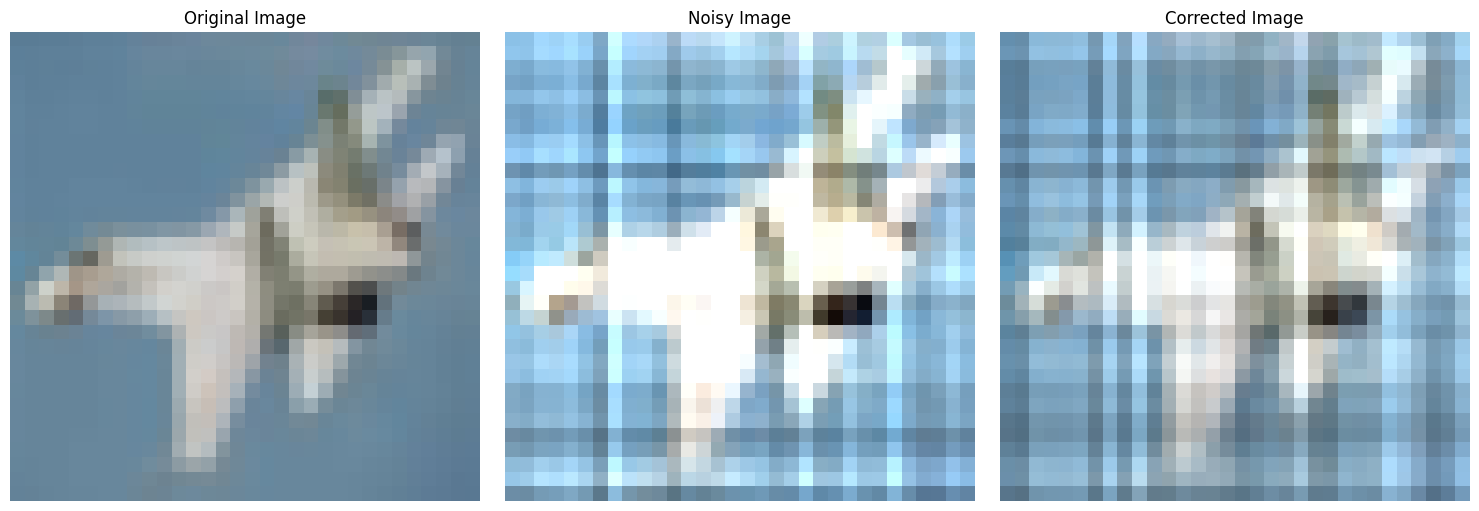

In [26]:
# Validate channel lists
assert len(hat_A_train_channels) == 3, "hat_A_train_channels does not have three channels"
assert len(hat_B_train_channels) == 3, "hat_B_train_channels does not have three channels"
index = 10

# Debug shapes
for c in range(3):
    print(f"hat_A_train_channels[{c}].shape: {hat_A_train_channels[c].shape}")
    print(f"X_train_modified[index][..., {c}].shape: {X_test_modified[index][..., c].shape}")
    print(f"hat_B_train_channels[{c}].shape: {hat_B_train_channels[c].shape}")

# Apply correction for each channel and recombine
corrected_image = np.stack(
    [
        np.dot(np.dot(hat_A_train_channels[c], X_test_modified[index][..., c]), hat_B_train_channels[c])
        for c in range(3)
    ],
    axis=-1,
)

# Clip corrected image to valid range
corrected_image = np.clip(corrected_image, 0.0, 1.0)

# Plot corrected image
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(X_test[index])
plt.title("Original Image")
plt.axis('off')

# Modified image
plt.subplot(1, 3, 2)
plt.imshow(X_test_modified[index].astype('float32'))
plt.title("Noisy Image")
plt.axis('off')

# Corrected image
plt.subplot(1, 3, 3)
plt.imshow(corrected_image)
plt.title("Corrected Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
from numpy.linalg import norm
import numpy as np

# Compute the distances for a specific index
index = 10  # Choose an image index

# Apply the correction for each channel
corrected_image = np.stack(
    [
        np.dot(np.dot(hat_A_train_channels[c], X_test_modified[index][..., c]), hat_B_train_channels[c])
        for c in range(3)
    ],
    axis=-1,
)

# Compute the Frobenius norm distances
distance_original_noisy = norm(X_test[index] - X_test_modified[index])**2
distance_original_corrected = norm(X_test[index] - corrected_image)**2

# Display the results
print(f"Distance between original and noisy image: {distance_original_noisy:.4f}")
print(f"Distance between original and corrected image: {distance_original_corrected:.4f}")


Distance between original and noisy image: 215.4360
Distance between original and corrected image: 79.8785


# Evolution of the Forbenius loss as a function of the noise factor

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

# Define the range of noise_factor values
noise_factors = np.linspace(0.005, 0.05, 5)

# Initialize lists to store the distances for each noise_factor
distance_original_noisy_list = []
distance_original_corrected_list = []


# Process for each noise_factor
for noise_factor in noise_factors:
    # Define the noise level (adjust as needed)

    # Create noisy matrices for transformation
    A_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
    # Normalize each row to have unit L1 norm
    A_noisy_L1 = A_noisy / np.abs(A_noisy).sum(axis=1, keepdims=True)
    A_noisy_L1_inv = np.linalg.inv(A_noisy_L1)

    B_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
    B_noisy_inv = np.linalg.inv(B_noisy)

    # Apply the transformation to the training and test datasets
    X_train_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_train])
    X_test_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_test])

    # Separate channels for original and modified datasets
    X_train_channels = reshape_by_channel(X_train)
    X_train_modified_channels = reshape_by_channel(X_train_modified)
    X_test_channels = reshape_by_channel(X_test)
    X_test_modified_channels = reshape_by_channel(X_test_modified)

    # Initialize lists to store results for each channel
    C_train_channels = []
    C_test_channels = []

    # Process each channel independently
    for c in range(3):  # Loop through RGB channels
        # Original and modified channel matrices
        X_train_channel = X_train_channels[c]
        X_train_modified_channel = X_train_modified_channels[c]
        X_test_channel = X_test_channels[c]
        X_test_modified_channel = X_test_modified_channels[c]
        
        # Compute covariance matrices
        X_train_modified_T_X_train_modified = np.dot(X_train_modified_channel.T, X_train_modified_channel)
        X_test_modified_T_X_test_modified = np.dot(X_test_modified_channel.T, X_test_modified_channel)

        # Compute pseudo-inverse
        X_train_modified_inv = np.linalg.pinv(X_train_modified_T_X_train_modified)
        X_test_modified_inv = np.linalg.pinv(X_test_modified_T_X_test_modified)

        # Compute projection matrices
        C_train = np.dot(
            np.dot(X_train_modified_inv, X_train_modified_channel.T),
            X_train_channel
        )
        C_test = np.dot(
            np.dot(X_test_modified_inv, X_test_modified_channel.T),
            X_test_channel
        )

        # Append results for the channel
        C_train_channels.append(C_train)
        C_test_channels.append(C_test)

    # Combine results for all channels if needed
    C_X_train_modified_matrix_hat = np.stack(C_train_channels, axis=0)
    C_X_test_modified_matrix_hat = np.stack(C_test_channels, axis=0)

    # Initialize matrices to store results for each channel
    hat_A_train_channels = []
    hat_B_train_channels = []

    for c in range(3):  # Loop through RGB channels
        # Extract dimensions for the current channel
        T, n, p, m, q = (X_train_modified_channels[c].shape[0],
                        32,
                        32,
                        32,
                        32)
        
        # Compute hat_A_train for the current channel
        hat_A_train = np.empty((n, m))
        for i in tqdm(range(1, n + 1), desc=f"Channel {c}: Computing hat_A_train"):
            for k in range(1, m + 1):
                numerator = np.sum(
                    C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                    for l in range(1, q + 1) for j in range(1, p + 1)
                )
                denominator = np.sum(
                    C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                    for l in range(1, q + 1) for j in range(1, p + 1)
                    for k in range(1, m + 1) for i in range(1, n + 1)
                )
                x = numerator * n / denominator
                hat_A_train[i - 1, k - 1] = min(max(0, x), 1)
        
        hat_A_train_channels.append(hat_A_train)

        print(f"Processing channel {c} for hat_B_train")

        hat_B_train = np.empty((q, p))  # Initialize the matrix for the current channel
        
        for l in tqdm(range(1, q + 1), desc=f"Channel {c}: Computing hat_B_train"):
            for j in range(1, p + 1):
                numerator = np.sum(
                    C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                    for k in range(1, m + 1) for i in range(1, n + 1)
                )
                hat_B_train[l - 1, j - 1] = numerator / n
    
        hat_B_train_channels.append(hat_B_train)  # Add the matrix for the current channel

        # Verify the size of hat_B_train_channels
        print(f"Number of channels in hat_B_train_channels: {len(hat_B_train_channels)}")

    for idx in tqdm(range(len(X_test_modified))):

        # Apply the correction for each channel
        corrected_image = np.stack(
            [
                np.dot(np.dot(hat_A_train_channels[c], X_test_modified[idx][..., c]), hat_B_train_channels[c])
                for c in range(3)
            ],
            axis=-1,
        )

        # Compute the Frobenius norm distances
        distance_original_noisy = norm(X_test[idx] - X_test_modified[idx])**2
        distance_original_corrected = norm(X_test[idx] - corrected_image)**2

        # Append the results to the lists
        distance_original_noisy_list.append(distance_original_noisy)
        distance_original_corrected_list.append(distance_original_corrected)



Channel 0: Computing hat_A_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/2648520210.py:91: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/2648520210.py:95: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(
Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [03:13<00:00,  6.06s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/dt/gxgjx9217qj05ds0946nwb700000gp/T/ipykernel_66576/2648520210.py:111: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 150.99it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 160.20it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [03:15<00:00,  6.12s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 160.69it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [03:16<00:00,  6.15s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 159.65it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [03:19<00:00,  6.23s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 156.43it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [03:20<00:00,  6.26s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 159.90it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [10:01<00:00, 18.80s/it] 


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 165.21it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 150.84it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [17:05<00:00, 32.06s/it] 


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 168.21it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [03:14<00:00,  6.09s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 153.12it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [03:16<00:00,  6.13s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 163.58it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [03:15<00:00,  6.12s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 150.84it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 160.35it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [03:17<00:00,  6.16s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 157.29it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [03:17<00:00,  6.17s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 150.93it/s]


Number of channels in hat_B_train_channels: 3


100%|██████████| 10000/10000 [00:00<00:00, 26411.56it/s]


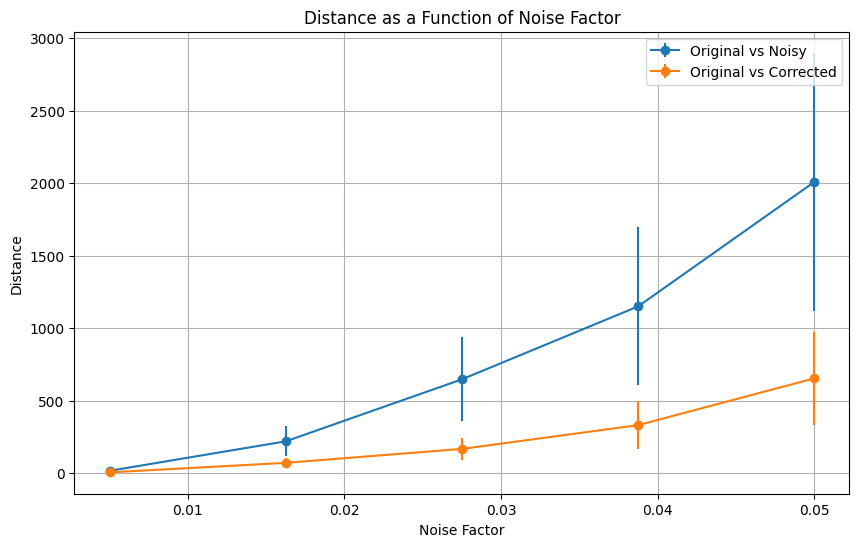

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
# Assuming distance_original_noisy_list is a flat list of length 500,000
# and noise_factor is a list of length 10
distance_original_noisy_array = np.array(distance_original_noisy_list)  # Convert to NumPy array
distance_original_corrected_array = np.array(distance_original_corrected_list)  # Convert to NumPy array
num_noise_factors = noise_factors.shape[0]  # Number of noise factor values
num_samples_per_factor = len(distance_original_noisy_array) // num_noise_factors  # Samples per noise factor

# Reshape the array into shape (num_noise_factors, num_samples_per_factor)
distance_original_noisy_array = distance_original_noisy_array.reshape(num_noise_factors, num_samples_per_factor)
distance_original_corrected_array = distance_original_corrected_array.reshape(num_noise_factors, num_samples_per_factor)

# Compute the mean and standard deviation for each noise factor
mean_distances_original_noisy = np.mean(distance_original_noisy_array, axis=1)
std_distances_original_noisy = np.std(distance_original_noisy_array, axis=1)
mean_distances_original_corrected = np.mean(distance_original_corrected_array, axis=1)
std_distances_original_corrected = np.std(distance_original_corrected_array, axis=1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(list(noise_factors), list(mean_distances_original_noisy), yerr=list(std_distances_original_noisy), fmt='o-', label='Original vs Noisy')
plt.errorbar(list(noise_factors), list(mean_distances_original_corrected), yerr=list(std_distances_original_corrected), fmt='o-', label='Original vs Corrected')
plt.xlabel("Noise Factor")
plt.ylabel("Distance")
plt.title("Distance as a Function of Noise Factor")
plt.grid(True)
plt.legend()
plt.show()
